<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_13_GPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Import the necessary libraries
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# GPU Implementation

In [2]:
# Activate the GPU
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Build a Simple Model
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2)
    )

In [4]:
# Create some data
data = torch.randn((1000,20)) # Samples and features
labels = torch.randint(low=0,high=2,size=(1,1000))
print(data.shape)
print(labels.shape)

torch.Size([1000, 20])
torch.Size([1, 1000])


In [5]:
# Send the model and data to the GPU from CPU
# device was specified above
# model
net.to(device)

# data
data = data.to(device)
labels = labels.to(device)

In [6]:
data

tensor([[-1.1899,  1.6501, -0.1273,  ..., -0.0087,  2.2450, -1.6927],
        [ 1.0297,  1.5349, -1.3686,  ..., -0.8144, -0.3644, -0.8344],
        [-0.2428,  0.5061, -0.5019,  ..., -1.1506, -0.1161,  1.2187],
        ...,
        [ 0.2101,  0.6502, -0.4615,  ..., -1.1105, -0.6496, -0.3511],
        [ 1.3287,  0.1899, -1.5452,  ...,  0.6918,  1.1985, -1.4783],
        [-0.8586,  2.0044,  0.0357,  ...,  1.1714, -1.0549,  1.4145]],
       device='cuda:0')

In [7]:
# You can also create data directly on GPU
dataG = torch.randn((1000,20), device=device)
dataC = torch.randn((1000,20), device="cpu")

print(data.device)
print(dataG.device)
print(dataC.device)

cuda:0
cuda:0
cpu


In [8]:
# Get results from the model
output = net(data)

In [9]:
# Output is still on GPU
output.device

device(type='cuda', index=0)

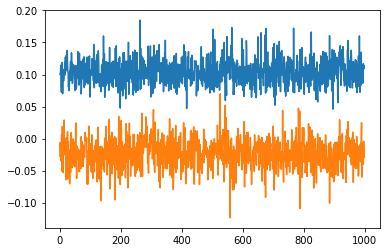

In [13]:
# Plot the data
# plt.plot(output.detach()) # Will not run because data is on GPU
plt.plot(output.detach().cpu())  # transfer the data on CPU
plt.show()

In [14]:
# Computation time
starttime = time.process_time()

# Move, run, retrieve
device = "cuda:0"
net.to(device)
data = data.to(device)
labels = labels.to(device)
# retrieve the output back to CPU
output = net(data).detach().cpu()

GPUtime = 1000*(time.process_time() - starttime)

In [15]:
# Computation time
starttime = time.process_time()

# Move, run, retrieve
device = "cpu"
net.to(device)
data = data.to(device)
labels = labels.to(device)
# retrieve the output back to CPU
output = net(data).detach().cpu()

CPUtime = 1000*(time.process_time() - starttime)

In [16]:
# Time in ms
[GPUtime, CPUtime]

[2.8120180000001938, 10.518568000000172]

In [17]:
# Do everything on CPU
net = nn.Sequential(
    nn.Linear(20,100),
    nn.ReLU(),
    nn.Linear(100,500),
    nn.ReLU(),
    nn.Linear(500,30),
    nn.ReLU(),
    nn.Linear(30,2)
    )

data = torch.randn((1000,20))

starttime = time.process_time()
output = net(data).detach()
CPUtime2 = 1000*(time.process_time() - starttime)

In [18]:
# Time in ms
[GPUtime, CPUtime, CPUtime2]

[2.8120180000001938, 10.518568000000172, 5.850148000000388]

# Run Experiment on GPU

In [20]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [21]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [22]:
# create a class for the model
def createTheMNISTNet(nUnits,nLayers):
    class mnistNet(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
          
            # create dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            ### input layer
            self.layers['input'] = nn.Linear(784,nUnits)
            
            ### hidden layers
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

            ### output layer
            self.layers['output'] = nn.Linear(nUnits,10)
    

        # forward pass
        def forward(self,x):
            # input layer
            x = self.layers['input'](x)

            # hidden layers
            for i in range(self.nLayers):
                x = F.relu( self.layers[f'hidden{i}'](x) )
        
            # return output layer
            x = self.layers['output'](x)
            return F.log_softmax(x,dim=1)

    # create the model instance
    net = mnistNet(nUnits,nLayers)
  
    # loss function
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01)

    return net,lossfun,optimizer

In [23]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ), NLLLoss(), SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [24]:
# Create a function to train the model
def function2trainTheModel(nUnits,nLayers):

    # number of epochs
    numepochs = 60
  
    # create a new model
    net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

    # Transfer the model to GPU
    net.to(device)

    # initialize losses
    losses    = torch.zeros((numepochs,2))
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc  = []
        batchLoss = []

        for X,y in train_loader:
        
            # Send the data to the GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # New! bring outputs back to the CPU
            yHat = yHat.cpu()
            y = y.cpu()

            # compute accuracy
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi,0] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader

        # Again transfer to the GPU
        X = X.to(device)
        y = y.to(device)
    
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
      
        # New! bring outputs back from the GPU
        yHat = yHat.cpu()
        y = y.cpu()

        # Retrieve test losses for each epoch
        losses[epochi,1] = lossfun(yHat,y).item()

        # Retrieve test accuracy for each epoch
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    # end epochs

    # function output
    return trainAcc,testAcc,losses,net

In [25]:
# Test once to make sure it works
trainAcc,testAcc,losses,net = function2trainTheModel(65,2)

In [26]:
# Run the model
#  In CPU it took 30 mins
#  In GPU it takes 13 mins

# number of hidden layers
numlayers = range(1,4)
# units per hidden layer
numunits  = np.arange(50,251,50)

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
    for layeridx in range(len(numlayers)):

        # create and train a fresh model
        trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

        # store the results (average of final 5 epochs)
        accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
        accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

        # print a friendly status message
        print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}') 

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


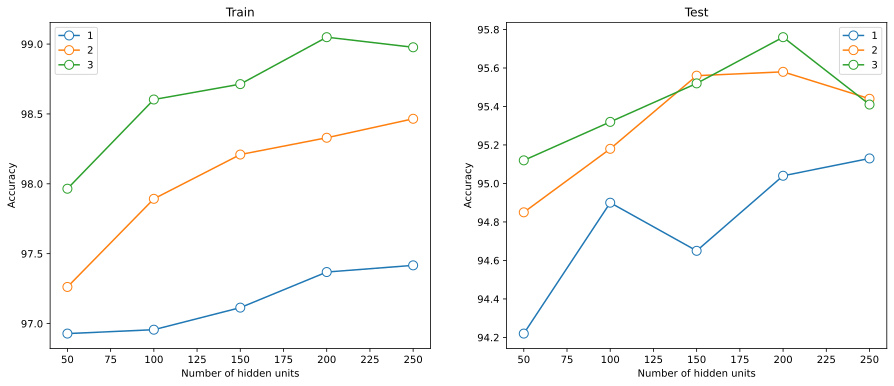

In [27]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
    ax[i].legend(numlayers)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()